<h1>Importing Libraries</h1>

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB

from custom_cnn_feature_extractor import CustomCNNFeatureExtractor
from data_preprocessing import train_loader

sns.set_theme(style="darkgrid", font_scale=1.5, rc={"axes.unicode_minus":False})

<h1>Visualization</h1>

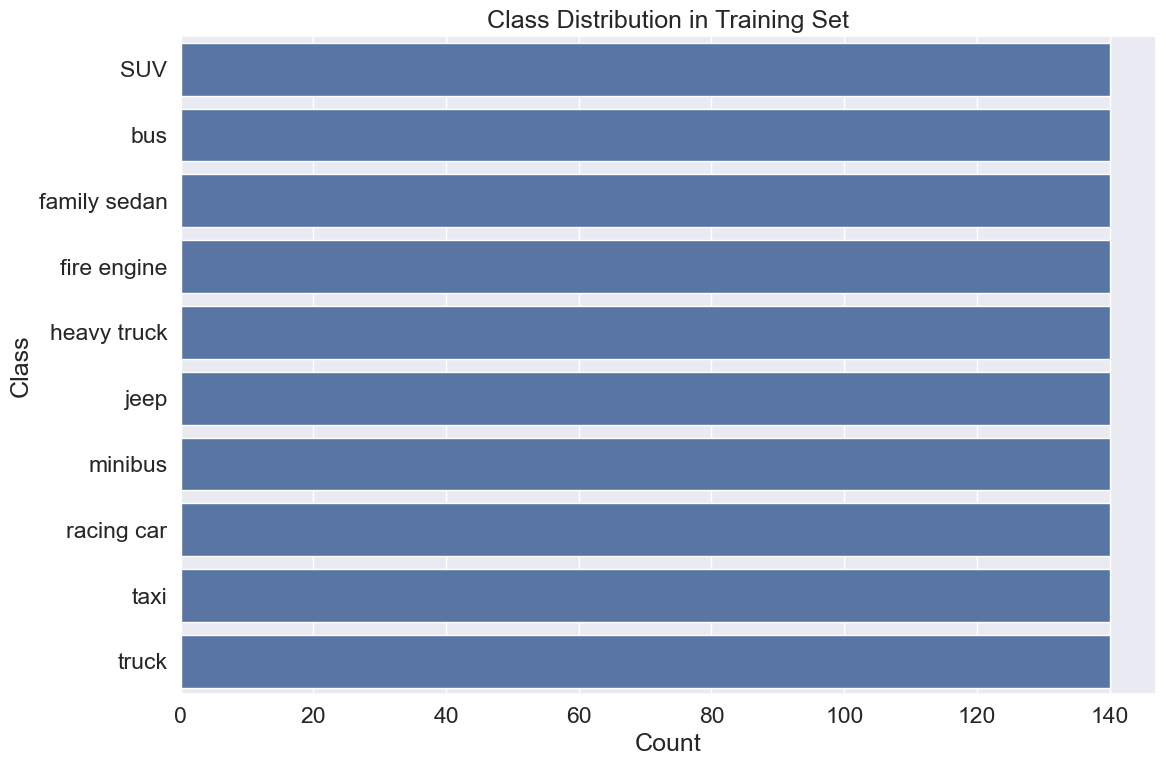

In [6]:
class_names = train_loader.dataset.classes
class_count = [train_loader.dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count})

plt.figure(figsize=(12, 8), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.title("Class Distribution in Training Set")
plt.tight_layout()
plt.show()

<h1>Load Features</h1>

In [8]:
def load_from_csv(file_path):
    data_df = pd.read_csv(file_path)
    labels = data_df["Class"].values
    features = data_df.drop("Class", axis=1).values
    return features, labels

# Load the pre-extracted features from CSV
train_features, train_labels = load_from_csv('../features/train_features.csv')
val_features, val_labels = load_from_csv('../features/val_features.csv')

<h1>Training</h1>

In [9]:
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(train_features, train_labels)

GaussianNB()

<h1>Predict On Validation Data</h1>

In [10]:
val_predictions = naive_bayes_model.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.3f}")

Validation Accuracy: 0.190


<h1>Confusion Matrix</h1>

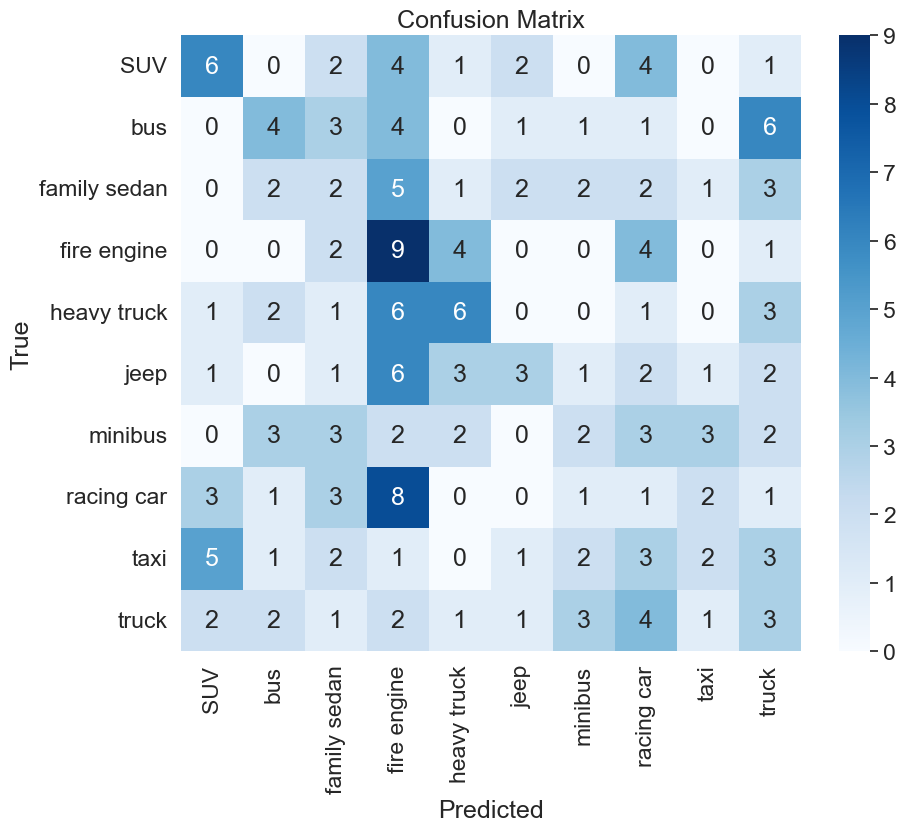

In [11]:
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()